In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import glob
from imblearn.over_sampling import SMOTE

In [ ]:
# master_df=pd.read_csv("/content/BlazePose_Data.csv")
master_df=pd.DataFrame()
lst_blz=glob.glob("/content/Blaze*")
for i in lst_blz:
  # print(i)
  temp_df=pd.read_csv(i)
  # print(temp_df.shape)
  master_df=master_df.append(temp_df)
master_df = master_df.loc[:, ~master_df.columns.str.contains('^Unnamed')]
print(master_df.shape)
master_df.head()

(7134, 7)


<ipython-input-104-34be1f417c59>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df=master_df.append(temp_df)


,Video_path,Frame_number,shoulder_distance,elbow_distance,shoulder_angle,arm_to_height_ratio,Person_number
0,/content/Anomaly_Videos/Assault/Assault013_x26...,51,0.825352,1.380282,-2.921909,-12.669692,5
1,/content/Anomaly_Videos/Assault/Assault013_x26...,81,0.233416,0.159275,3.090152,-11.746744,2
2,/content/Anomaly_Videos/Assault/Assault013_x26...,111,0.917443,1.149235,-3.083697,-30.507757,2
3,/content/Anomaly_Videos/Assault/Assault013_x26...,141,0.108606,0.059077,-3.065977,1.073312,3
4,/content/Anomaly_Videos/Assault/Assault013_x26...,201,0.321555,0.125002,3.041822,2.429184,3


In [ ]:
label=[]
for i in range(master_df.shape[0]):
  # print(i)
  strx=master_df.iloc[i]["Video_path"]
  # print(strx)
  if "Abuse" in strx:
    label.append("Abuse")
  elif "Arrest" in strx:
    label.append("Arrest")
  elif "Arson" in strx:
    label.append("Arson")#
  elif "Assult" in strx:
    label.append("Assult")#
  elif "Burglary" in strx:
    label.append("Burglary")
  elif "Fighting" in strx:
    label.append("Fighting")
  elif "Normal" in strx:
    label.append("Normal")
  elif "Robbery" in strx:
    label.append("Robbery")
  elif "Shooting" in strx:
    label.append("Shooting")
  elif "Shoplifting" in strx:
    label.append("Shoplifting")
  elif "Stealing" in strx:
    label.append("Stealing")#
  elif "Vandalism" in strx:
    label.append("Vandalism")
  else:
    label.append("Unknown")
master_df["Activity_Recognition_Label"]=label


In [ ]:
master_df=master_df[~master_df["Activity_Recognition_Label"].isin(["Unknown","Normal"])]
master_df["Activity_Recognition_Label"].value_counts()

Burglary       1992
Fighting       1542
Arrest          882
Shoplifting     568
Robbery         414
Abuse           310
Stealing        166
Vandalism       154
Shooting         72
Arson            48
Name: Activity_Recognition_Label, dtype: int64

In [ ]:
master_df.head()

,Video_path,Frame_number,shoulder_distance,elbow_distance,shoulder_angle,arm_to_height_ratio,Person_number,Activity_Recognition_Label
240,/content/Anomaly_Videos/Vandalism/Vandalism025...,136,0.019738,0.058205,-2.675520,2.696296,1,Vandalism
241,/content/Anomaly_Videos/Vandalism/Vandalism025...,166,0.244076,0.222307,-2.869226,-4.649397,1,Vandalism
242,/content/Anomaly_Videos/Vandalism/Vandalism025...,196,0.259568,0.347421,-3.024840,-19.161695,1,Vandalism
243,/content/Anomaly_Videos/Vandalism/Vandalism025...,826,0.041568,0.080042,-2.548320,-5.685189,1,Vandalism
244,/content/Anomaly_Videos/Vandalism/Vandalism025...,1036,0.285964,0.503714,-1.767956,-3.042181,1,Vandalism


# Detecting activity type

In [ ]:
features=['shoulder_distance', 'elbow_distance', 'shoulder_angle',
       'arm_to_height_ratio']

In [ ]:
le = LabelEncoder()
master_df['Activity_Recognition_Label'] = le.fit_transform(master_df['Activity_Recognition_Label'])
X = master_df.drop('Activity_Recognition_Label', axis=1)[features].values
Y = master_df['Activity_Recognition_Label'].values

In [ ]:
master_df['Activity_Recognition_Label'].value_counts()

3    1992
4    1542
1     882
7     568
5     414
0     310
8     166
9     154
6      72
2      48
Name: Activity_Recognition_Label, dtype: int64

In [ ]:
num_classes=len(master_df["Activity_Recognition_Label"].unique())
num_classes

10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4918, 4) (1230, 4) (4918,) (1230,)


In [ ]:
# Standardize features using z-score normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15880, 4) (1230, 4) (15880,) (1230,)


# Build DNN Model

In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    # tf.keras.layers.Input(shape=(X_train_scaled_reshaped.shape[0],X_test_scaled_reshaped.shape[1])),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(128, activation='relu'),
    # # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1)
history=model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/100
993/993 [==============================] - 10s 9ms/step - loss: 2.2491 - accuracy: 0.1530 - val_loss: 2.2152 - val_accuracy: 0.1797
Epoch 2/100
993/993 [==============================] - 9s 9ms/step - loss: 2.1442 - accuracy: 0.2098 - val_loss: 2.1786 - val_accuracy: 0.1748
Epoch 3/100
993/993 [==============================] - 9s 9ms/step - loss: 2.0771 - accuracy: 0.2457 - val_loss: 2.1704 - val_accuracy: 0.1870
Epoch 4/100
993/993 [==============================] - 8s 8ms/step - loss: 2.0252 - accuracy: 0.2650 - val_loss: 2.1534 - val_accuracy: 0.1463
Epoch 5/100
993/993 [==============================] - 9s 9ms/step - loss: 1.9919 - accuracy: 0.2766 - val_loss: 2.0947 - val_accuracy: 0.1846
Epoch 6/100
993/993 [==============================] - 9s 9ms/step - loss: 1.9641 - accuracy: 0.2885 - val_loss: 2.0738 - val_accuracy: 0.2236
Epoch 7/100
993/993 [==============================] - 8s 8ms/step - loss: 1.9408 - accuracy: 0.2957 - val_loss: 2.0648 - val_accuracy: 0.229

In [ ]:

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode integer labels back to original species labels
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred_classes)

# Print classification report
print(classification_report(y_test_original, y_pred_original))

39/39 [==============================] - 0s 3ms/step - loss: 1.9955 - accuracy: 0.2366
Test Loss: 1.9955, Test Accuracy: 0.2366
39/39 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       Abuse       0.15      0.39      0.21        61
      Arrest       0.35      0.33      0.34       162
       Arson       0.08      1.00      0.16         7
    Burglary       0.76      0.15      0.24       404
    Fighting       0.48      0.13      0.21       306
     Robbery       0.16      0.31      0.21        85
    Shooting       0.03      0.33      0.06        12
 Shoplifting       0.33      0.36      0.34       121
    Stealing       0.16      0.38      0.22        37
   Vandalism       0.11      0.54      0.19        35

    accuracy                           0.24      1230
   macro avg       0.26      0.39      0.22      1230
weighted avg       0.47      0.24      0.25      1230



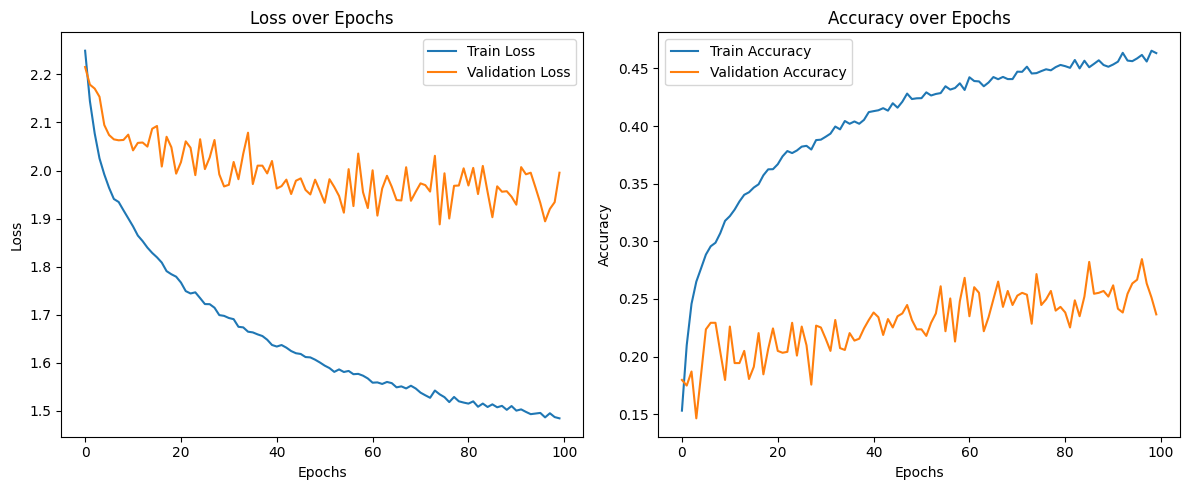

In [ ]:
import matplotlib.pyplot as plt

# Get loss and accuracy values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
ax1.plot(train_loss, label='Train Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()

# Plot accuracy
ax2.plot(train_accuracy, label='Train Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.legend()

plt.tight_layout()
plt.show()

# Build XGB

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Define the parameter grid to search through
param_grid = {
    'n_estimators': [25,50, 100, 150],
    'max_depth': [1,3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)

# Perform the grid search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Best Accuracy:", accuracy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Best Accuracy: 0.8048780487804879


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        61
           1       0.78      0.88      0.83       162
           2       0.70      1.00      0.82         7
           3       0.88      0.78      0.83       404
           4       0.85      0.80      0.82       306
           5       0.72      0.67      0.70        85
           6       0.67      0.83      0.74        12
           7       0.70      0.84      0.77       121
           8       0.72      0.78      0.75        37
           9       0.57      0.83      0.67        35

    accuracy                           0.80      1230
   macro avg       0.75      0.83      0.78      1230
weighted avg       0.81      0.80      0.81      1230



In [ ]:
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)
print(classification_report(y_test_original, y_pred_original))

              precision    recall  f1-score   support

       Abuse       0.86      0.90      0.88        61
      Arrest       0.78      0.88      0.83       162
       Arson       0.70      1.00      0.82         7
    Burglary       0.88      0.78      0.83       404
    Fighting       0.85      0.80      0.82       306
     Robbery       0.72      0.67      0.70        85
    Shooting       0.67      0.83      0.74        12
 Shoplifting       0.70      0.84      0.77       121
    Stealing       0.72      0.78      0.75        37
   Vandalism       0.57      0.83      0.67        35

    accuracy                           0.80      1230
   macro avg       0.75      0.83      0.78      1230
weighted avg       0.81      0.80      0.81      1230



# Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.864672562833687
Test Accuracy: 0.8569105691056911


In [ ]:
# Predict using the best estimator
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        61
           1       0.84      0.93      0.88       162
           2       0.56      0.71      0.63         7
           3       0.90      0.87      0.88       404
           4       0.88      0.85      0.86       306
           5       0.83      0.69      0.76        85
           6       0.55      1.00      0.71        12
           7       0.84      0.88      0.86       121
           8       0.87      0.73      0.79        37
           9       0.69      0.89      0.78        35

    accuracy                           0.86      1230
   macro avg       0.78      0.84      0.80      1230
weighted avg       0.86      0.86      0.86      1230



In [ ]:
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)
print(classification_report(y_test_original, y_pred_original))

              precision    recall  f1-score   support

       Abuse       0.87      0.87      0.87        61
      Arrest       0.84      0.93      0.88       162
       Arson       0.56      0.71      0.63         7
    Burglary       0.90      0.87      0.88       404
    Fighting       0.88      0.85      0.86       306
     Robbery       0.83      0.69      0.76        85
    Shooting       0.55      1.00      0.71        12
 Shoplifting       0.84      0.88      0.86       121
    Stealing       0.87      0.73      0.79        37
   Vandalism       0.69      0.89      0.78        35

    accuracy                           0.86      1230
   macro avg       0.78      0.84      0.80      1230
weighted avg       0.86      0.86      0.86      1230




# LightGBM


In [ ]:
import lightgbm as lgb


In [ ]:

# Define the parameter grid for GridSearchCV
param_grid = {
    'num_leaves': [20, 30, 40],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Predict using the best estimator
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print(classification_report(y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 40}
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        61
           1       0.62      0.73      0.67       162
           2       0.24      0.71      0.36         7
           3       0.81      0.61      0.69       404
           4       0.74      0.60      0.66       306
           5       0.52      0.60      0.56        85
           6       0.37      0.83      0.51        12
           7       0.61      0.74      0.67       121
           8       0.43      0.65      0.52        37
           9       0.43      0.77      0.55        35

    accuracy                           0.65      1230
   macro avg       0.53      0.70      0.58      1230
weighted avg       0.69      0.65      0.66      1230



In [ ]:
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)
print(classification_report(y_test_original, y_pred_original))

              precision    recall  f1-score   support

       Abuse       0.58      0.74      0.65        61
      Arrest       0.62      0.73      0.67       162
       Arson       0.24      0.71      0.36         7
    Burglary       0.81      0.61      0.69       404
    Fighting       0.74      0.60      0.66       306
     Robbery       0.52      0.60      0.56        85
    Shooting       0.37      0.83      0.51        12
 Shoplifting       0.61      0.74      0.67       121
    Stealing       0.43      0.65      0.52        37
   Vandalism       0.43      0.77      0.55        35

    accuracy                           0.65      1230
   macro avg       0.53      0.70      0.58      1230
weighted avg       0.69      0.65      0.66      1230

